<a href="https://colab.research.google.com/github/uhdang/mlim_group_3_final_assignment/blob/main/quang/FinalAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [154]:
!pip install scikit-learn --upgrade

     |████████████████████████████████| 22.3MB 1.8MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [79]:
!pip install lightgbm --upgrade

     |████████████████████████████████| 1.8MB 6.6MB/s 
  Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [3]:
import pandas as pd
import numpy as np
# from datastreamer import DataStreamerP2V
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')
baskets = pd.read_parquet("/content/drive/MyDrive/My Drive/baskets.parquet")
coupons = pd.read_parquet("/content/drive/MyDrive/My Drive/coupons.parquet")
# coupon_index = pd.read_parquet("/content/drive/MyDrive/My Drive/coupon_index.parquet")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
baskets['target'] = 1
baskets

,week,shopper,product,price,target
0,0,0,71,629,1
1,0,0,91,605,1
2,0,0,116,715,1
3,0,0,123,483,1
4,0,0,157,592,1
...,...,...,...,...,...
68841593,89,99999,143,470,1
68841594,89,99999,158,566,1
68841595,89,99999,186,499,1
68841596,89,99999,204,496,1


In [6]:
coupons

,week,shopper,product,discount
0,0,0,35,35
1,0,0,193,40
2,0,0,27,30
3,0,0,177,35
4,0,0,5,30
...,...,...,...,...
44999995,89,99999,62,40
44999996,89,99999,110,10
44999997,89,99999,37,40
44999998,89,99999,155,25


In [7]:
#baskets[['week', 'shopper', 'product']] = baskets[['week', 'shopper', 'product']].astype('category')
# baskets[['shopper', 'product']] = baskets[['shopper', 'product']].astype('category')
baskets['product'] = baskets['product'].astype('category')
coupons['product'] = coupons['product'].astype('category')

# Split Data

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
weeks = 89 
shoppers = 100

baskets_train = baskets.loc[(baskets.shopper.isin(list(range(shoppers)))) & (baskets.week<weeks), :]
baskets_test = baskets.loc[(baskets.shopper.isin(list(range(shoppers)))) & (baskets.week>=weeks), :]

coupons_train = coupons.loc[(coupons.shopper.isin(list(range(shoppers)))) & (coupons.week<weeks), :]
coupons_test = coupons.loc[(coupons.shopper.isin(list(range(shoppers)))) & (coupons.week>=weeks), :]

In [10]:
baskets_train['shopper'] = baskets_train['shopper'].astype('category')
coupons_train['shopper'] = coupons_train['shopper'].astype('category')

# baskets_train['target'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
baskets_train

,week,shopper,product,price,target
0,0,0,71,629,1
1,0,0,91,605,1
2,0,0,116,715,1
3,0,0,123,483,1
4,0,0,157,592,1
...,...,...,...,...,...
67312654,88,99,142,551,1
67312655,88,99,176,681,1
67312656,88,99,187,663,1
67312657,88,99,199,604,1


In [12]:
coupons_train

,week,shopper,product,discount
0,0,0,35,35
1,0,0,193,40
2,0,0,27,30
3,0,0,177,35
4,0,0,5,30
...,...,...,...,...
44000495,88,99,160,40
44000496,88,99,31,40
44000497,88,99,141,15
44000498,88,99,14,30


# Data Preprocessing

In [13]:
# Counting weeks of prior order for each product/customer
# baskets_train['weeks_since_prior_order'] = baskets_train.groupby(['shopper', 'product']).week.apply(lambda x: x.diff()) # change to count weeks since last order, even when it wasn't bought

In [14]:
full_df_train = (baskets_train
           .merge(
               coupons_train, 
               on=['week', 'shopper', 'product'], 
               how='outer',
               indicator=True
           )
           .sort_values(by=['week', 'shopper', 'product'])
           .reset_index(drop=True)
          #  .replace(['left_only', 'right_only', 'both'], ['RRP', 'coupon', 'discounted'])
          .replace(['left_only', 'right_only', 'both'], ['No', 'Yes', 'Yes'])
          .rename(columns={'_merge': 'coupon'})
)

full_df_train.loc[full_df_train['discount'].isna(),'discount' ] = 0

In [15]:
full_df_train

,week,shopper,product,price,target,discount,coupon
0,0,0,5,NaN,NaN,30.0,Yes
1,0,0,27,NaN,NaN,30.0,Yes
2,0,0,35,NaN,NaN,35.0,Yes
3,0,0,71,629.0,1.0,0.0,No
4,0,0,91,605.0,1.0,0.0,No
...,...,...,...,...,...,...,...
109678,88,99,160,NaN,NaN,40.0,Yes
109679,88,99,176,681.0,1.0,0.0,No
109680,88,99,187,663.0,1.0,0.0,No
109681,88,99,199,604.0,1.0,0.0,No


# Feature Engineering

In [16]:
original_price = baskets.groupby('product', as_index=False).price.max().rename(columns={'price': 'original_price'})
total_count_of_product = baskets_train.groupby(['shopper', 'product']).product.count().to_frame('total_count_of_product').reset_index()
reordered = (baskets_train.groupby(['shopper']).product.value_counts()>1).astype(int)
average_price_per_shopper = baskets_train.groupby(['shopper']).price.mean().to_frame('average_price_per_shopper').reset_index()
average_basket_size = baskets_train.groupby(['shopper', 'week']).product.count().groupby('shopper').mean().to_frame('average_basket_size').reset_index()
unique_products_per_shopper = baskets_train.groupby(['shopper']).product.nunique()
ratio_of_reordered_per_shopper = (reordered.groupby('shopper').sum() / unique_products_per_shopper).to_frame('ratio_of_reordered').reset_index()

ratio_of_reordered_per_product = total_count_of_product.copy()
ratio_of_reordered_per_product['total_count_of_product'] = total_count_of_product['total_count_of_product'] / (baskets_train.week.max()+1)
ratio_of_reordered_per_product.rename(columns={'total_count_of_product': 'ratio_of_reordered_per_product'}, inplace=True)

reordered = reordered.to_frame('reordered').reset_index()
unique_products_per_shopper = unique_products_per_shopper.to_frame('unique_products_per_shopper').reset_index()

# frequency_per_product = 

# feature which give less probability to products wich haven't been purchased for a long time -> maybe relates to category as shopper has changed to product in similar category
# add average week interval for each product and shopper -> frequency | maybe not necessary, basically just total_count/weeks, probably already covered by model
# WoE

# Set Up Training Table

In [17]:
df1 = pd.DataFrame({'key':np.ones(weeks), 'week':list(range(weeks))})
df2 = pd.DataFrame({'key':np.ones(shoppers), 'shopper':list(range(shoppers))})
df3 = pd.DataFrame({'key':np.ones(250), 'product':list(range(250))})
df4 = full_df_train.copy()

X_train = pd.merge(df1, df2, on='key').merge(df3, on='key').merge(df4, on=['week', 'shopper', 'product'], how='left')[full_df_train.columns]

Combine everything

In [18]:
X_train = (X_train
           .merge(original_price, on=['product'], how='left')
           .merge(total_count_of_product, on=['shopper', 'product'], how='left')
           .merge(reordered, on=['shopper', 'product'], how='left')
           .merge(ratio_of_reordered_per_product, on=['shopper', 'product'], how='left')
           .merge(ratio_of_reordered_per_shopper, on=['shopper'], how='left')
           .merge(average_price_per_shopper, on=['shopper'], how='left')
           .merge(average_basket_size, on=['shopper'], how='left')
           .merge(unique_products_per_shopper, on=['shopper'], how='left')
           )

In [19]:
X_train

,week,shopper,product,price,target,discount,coupon,original_price,total_count_of_product,reordered,ratio_of_reordered_per_product,ratio_of_reordered,average_price_per_shopper,average_basket_size,unique_products_per_shopper
0,0,0,0,NaN,NaN,NaN,NaN,688,0,NaN,0.000000,0.722222,587.203947,8.539326,54
1,0,0,1,NaN,NaN,NaN,NaN,560,0,NaN,0.000000,0.722222,587.203947,8.539326,54
2,0,0,2,NaN,NaN,NaN,NaN,773,0,NaN,0.000000,0.722222,587.203947,8.539326,54
3,0,0,3,NaN,NaN,NaN,NaN,722,0,NaN,0.000000,0.722222,587.203947,8.539326,54
4,0,0,4,NaN,NaN,NaN,NaN,620,8,1.0,0.089888,0.722222,587.203947,8.539326,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2224995,88,99,245,NaN,NaN,NaN,NaN,549,0,NaN,0.000000,0.763158,618.717752,8.797753,76
2224996,88,99,246,NaN,NaN,NaN,NaN,702,41,1.0,0.460674,0.763158,618.717752,8.797753,76
2224997,88,99,247,NaN,NaN,NaN,NaN,670,0,NaN,0.000000,0.763158,618.717752,8.797753,76
2224998,88,99,248,NaN,NaN,NaN,NaN,490,0,NaN,0.000000,0.763158,618.717752,8.797753,76


In [20]:
X_train.isnull().any()

week                              False
shopper                           False
product                           False
price                              True
target                             True
discount                           True
coupon                             True
original_price                    False
total_count_of_product            False
reordered                          True
ratio_of_reordered_per_product    False
ratio_of_reordered                False
average_price_per_shopper         False
average_basket_size               False
unique_products_per_shopper       False
dtype: bool

In [21]:
X_train['discount'].fillna(0, inplace=True)
X_train['price'].fillna(X_train.original_price*(1-X_train.discount), inplace=True)
X_train['reordered'].fillna(0, inplace=True)
X_train['coupon'].fillna('No', inplace=True)
# X_train['weeks_since_prior_order'].fillna(0, inplace=True)
X_train['target'].fillna(0, inplace=True)

In [22]:
addkey = X_train.groupby(['shopper','product']).target.apply(lambda x : x.eq(1).shift().fillna(0).cumsum())
X_train['weeks_since_prior_order'] = X_train.target.eq(0).groupby([X_train['shopper'], X_train['product'], addkey]).cumcount().add(1) # .cumsum()

In [23]:
X_train.head(3)

,week,shopper,product,price,target,discount,coupon,original_price,total_count_of_product,reordered,ratio_of_reordered_per_product,ratio_of_reordered,average_price_per_shopper,average_basket_size,unique_products_per_shopper,weeks_since_prior_order
0,0,0,0,688.0,0.0,0.0,No,688,0,0.0,0.0,0.722222,587.203947,8.539326,54,1
1,0,0,1,560.0,0.0,0.0,No,560,0,0.0,0.0,0.722222,587.203947,8.539326,54,1
2,0,0,2,773.0,0.0,0.0,No,773,0,0.0,0.0,0.722222,587.203947,8.539326,54,1


In [24]:
# X_train.loc[(X_train['shopper']==0) & (X_train['product']==116)][['week', 'weeks_since_prior_order', 'target']][:50]

In [25]:
X_train.drop('week', inplace=True, axis=1)

In [26]:
y_train = X_train.pop('target')

# Set Up Test Table

In [27]:
full_df_test = (baskets_test
           .merge(
               coupons_test, 
               on=['week', 'shopper', 'product'], 
               how='outer',
               indicator=True
           )
           .sort_values(by=['week', 'shopper', 'product'])
           .reset_index(drop=True)
          #  .replace(['left_only', 'right_only', 'both'], ['RRP', 'coupon', 'discounted'])
          .replace(['left_only', 'right_only', 'both'], ['No', 'Yes', 'Yes'])
          .rename(columns={'_merge': 'coupon'})
)

full_df_test.loc[full_df_test['discount'].isna(),'discount' ] = 0

In [28]:
df1 = pd.DataFrame({'key': np.ones(len(baskets_test.week.unique())), 'week': baskets_test.week.unique()})
df2 = pd.DataFrame({'key': np.ones(shoppers), 'shopper': list(range(shoppers))})
df3 = pd.DataFrame({'key': np.ones(250), 'product': list(range(250))})
df4 = full_df_test.copy()

X_test = pd.merge(df1, df2, on='key').merge(df3, on='key').merge(df4, on=['week', 'shopper', 'product'], how='left')[full_df_test.columns]

In [29]:
X_test = (X_test
           .merge(original_price, on=['product'], how='left')
           .merge(total_count_of_product, on=['shopper', 'product'], how='left')
           .merge(reordered, on=['shopper', 'product'], how='left')
           .merge(ratio_of_reordered_per_product, on=['shopper', 'product'], how='left')
           .merge(ratio_of_reordered_per_shopper, on=['shopper'], how='left')
           .merge(average_price_per_shopper, on=['shopper'], how='left')
           .merge(average_basket_size, on=['shopper'], how='left')
           .merge(unique_products_per_shopper, on=['shopper'], how='left')
           )

In [30]:
X_test['discount'].fillna(0, inplace=True)
X_test['price'].fillna(X_test.original_price*(1-X_test.discount), inplace=True)
X_test['reordered'].fillna(0, inplace=True)
X_test['coupon'].fillna('No', inplace=True)
# X_train['weeks_since_prior_order'].fillna(0, inplace=True)
X_test['target'].fillna(0, inplace=True)

In [31]:
last_weeks_since_prior_order = X_train.groupby(['shopper', 'product']).weeks_since_prior_order.last() + 1

In [32]:
X_test = X_test.merge(last_weeks_since_prior_order, on=['shopper', 'product'])

In [33]:
X_test.drop('week', inplace=True, axis=1)

In [34]:
y_test = X_test.pop('target')

# One-Hot Encoding Products

In [35]:
# from sklearn.preprocessing import OneHotEncoder

In [36]:
# enc = OneHotEncoder(sparse=False)

# encodings = X_train.select_dtypes(exclude=np.number).columns.tolist()
# # encoded = pd.DataFrame.sparse.from_spmatrix(enc.fit_transform(X_train[encodings]))
# encoded = pd.DataFrame(enc.fit_transform(X_train[encodings]))
# encoded.columns = enc.get_feature_names(encodings)

# X_train = pd.concat([X_train, encoded], axis=1).drop(encodings, axis=1)

In [37]:
# X_train = X_train.apply(pd.to_numeric)

In [38]:
# X_train.head(3)

# Training

In [39]:
from lightgbm.sklearn import LGBMClassifier

In [40]:
from collections import Counter

# count examples in each class
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]

lgb_clf = LGBMClassifier(
    scale_pos_weight=estimate
    )

In [41]:
categorical = X_train.select_dtypes(exclude=np.number).columns.tolist()
for cats in categorical:
  X_train[cats] = X_train[cats].astype('category')
  X_test[cats] = X_test[cats].astype('category')

In [42]:
lgb_clf.fit(X_train, y_train)

LGBMClassifier(scale_pos_weight=31.749002811262713)

In [43]:
lgb_clf.score(X_train, y_train)

0.8729325842696629

In [44]:
lgb_clf.score(X_test, y_test)

0.85824

## Evaluation

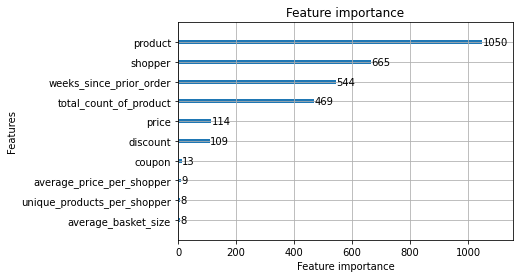

In [45]:
lgb.plot_importance(lgb_clf, max_num_features=10)

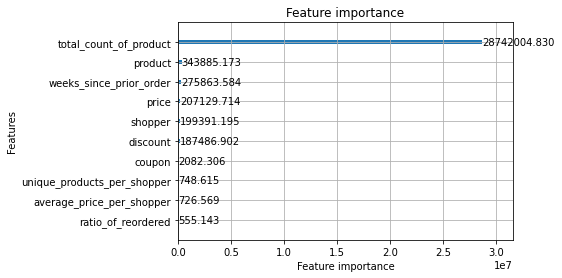

In [46]:
lgb.plot_importance(lgb_clf, max_num_features=10, importance_type='gain')

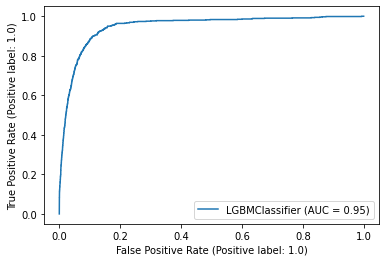

In [47]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(estimator=lgb_clf, X=X_test, y=y_test)

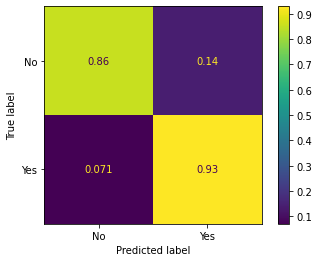

In [48]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = lgb_clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(estimator=lgb_clf, X=X_test, y_true=y_test, display_labels=['No', 'Yes'], normalize='true')

In [49]:
confusion

array([[20788,  3493],
       [   51,   668]])

In [50]:
FP = confusion[0][1]
FN = confusion[1][0]
TP = confusion[1][1]
TN = confusion[0][0]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# Precision
PPV = TP/(TP+FP)
# False discovery rate -> 1-Precision
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [51]:
print(f'TPR: {TPR:.4f}')
print(f'TNR: {TNR:.4f}')
print(f'FPR: {FPR:.4f}')
print(f'FNR: {FNR:.4f}')
print(f'Precision: {PPV:.4f}')
print(f'False discovery rate: {FDR:.4f}')

TPR: 0.9291
TNR: 0.8561
FPR: 0.1439
FNR: 0.0709
Precision: 0.1605
False discovery rate: 0.8395


### Old weeks_prior
shoppers = 100

**scale pos weight=1:**

TPR: 0.0459

TNR: 1.0000

FPR: 0.0000

FNR: 0.9541

Precision: 1.0000

False discovery rate: 0.0000


**scale pos weight=estimate:**

TPR: 0.9318

TNR: 0.8589

FPR: 0.1411

FNR: 0.0682

Precision: 0.1636

False discovery rate: 0.8364

### New weeks_prior

shoppers = 100

**scale pos weight=1:**

TPR: 0.2559

TNR: 0.9930

FPR: 0.0070

FNR: 0.7441

Precision: 0.5183

False discovery rate: 0.4817


**scale pos weight=estimate:**

TPR: 0.9318

TNR: 0.8563

FPR: 0.1437

FNR: 0.0682

Precision: 0.1611

False discovery rate: 0.8389

## evaluating specific examples

In [52]:
pd.DataFrame(lgb_clf.predict_proba(X_test))

,0,1
0,0.999979,0.000021
1,0.999977,0.000023
2,0.999979,0.000021
3,0.999978,0.000022
4,0.229559,0.770441
...,...,...
24995,0.999985,0.000015
24996,0.035755,0.964245
24997,0.999976,0.000024
24998,0.999980,0.000020


In [53]:
pred_frame = pd.concat((X_test, y_test, pd.DataFrame(lgb_clf.predict_proba(X_test))[1]), axis=1)[['shopper', 'product', 'target', 'weeks_since_prior_order', 1]]

In [54]:
pred_frame.head(10)

,shopper,product,target,weeks_since_prior_order,1
0,0,0,0.0,90,0.000021
1,0,1,0.0,90,0.000023
2,0,2,0.0,90,0.000021
3,0,3,0.0,90,0.000022
4,0,4,0.0,19,0.770441
5,0,5,0.0,90,0.000012
6,0,6,0.0,90,0.000017
7,0,7,0.0,90,0.000019
8,0,8,0.0,90,0.000021
9,0,9,0.0,90,0.000016


In [55]:
pred_frame.loc[(pred_frame['shopper']==0) & (pred_frame['product']==4)]

,shopper,product,target,weeks_since_prior_order,1
4,0,4,0.0,19,0.770441


In [56]:
baskets_train.loc[
            (baskets_train['shopper']==0) 
            & (baskets_train['product']==4)
            & (baskets_train['target']==1)
]

,week,shopper,product,price,target
18360597,24,0,4,620,1
30596544,40,0,4,620,1
34421333,45,0,4,620,1
39009343,51,0,4,620,1
41304982,54,0,4,620,1
44365285,58,0,4,620,1
45895349,60,0,4,620,1
53543562,70,0,4,620,1


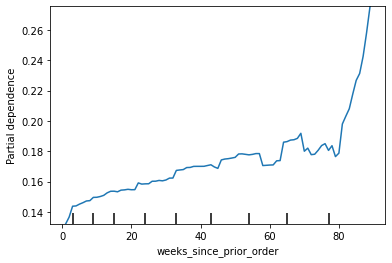

In [57]:
from sklearn.inspection import plot_partial_dependence

plot_partial_dependence(estimator=lgb_clf, X=X_train, features=['weeks_since_prior_order'])

# Hypertuning

In [50]:
# !pip install --quiet optuna

# import optuna

In [51]:
# clf = LGBMClassifier()

# param_distributions = {
#     'n_estimators': optuna.distributions.IntUniformDistribution(10, 500),
#     'num_leaves': optuna.distributions.IntUniformDistribution(2, 50),
#     'min_data_in_leaf': optuna.distributions.IntUniformDistribution(100, 400),
#     'feature_fraction': optuna.distributions.LogUniformDistribution(0.5, 1),
# #     'max_depth': optuna.distributions.IntUniformDistribution(-1, 200),
#     'subsample': optuna.distributions.LogUniformDistribution(0.5, 1),
# }

# optuna_search = optuna.integration.OptunaSearchCV(
#     estimator=clf, 
#     param_distributions=param_distributions, 
#     n_trials=50, 
#     timeout=7200,
#     cv=
# )

# optuna_search.fit(X_train, y_train)